In [1]:
import os
if os.system('pip show catboost'):
    !pip install catboost
if os.system('pip show category-encoders'):
    !pip install category_encoders
if os.system('pip show lightgbm'):
    !pip install lightgbm

Name: catboost
Version: 1.2
Summary: CatBoost Python Package
Home-page: https://catboost.ai
Author: CatBoost Developers
Author-email: 
License: Apache License, Version 2.0
Location: /home/oslik/.local/lib/python3.10/site-packages
Requires: graphviz, matplotlib, numpy, pandas, plotly, scipy, six
Required-by: 
Name: category-encoders
Version: 2.6.1
Summary: A collection of sklearn transformers to encode categorical variables as numeric
Home-page: https://github.com/scikit-learn-contrib/category_encoders
Author: Will McGinnis
Author-email: will@pedalwrencher.com
License: BSD
Location: /home/oslik/.local/lib/python3.10/site-packages
Requires: numpy, pandas, patsy, scikit-learn, scipy, statsmodels
Required-by: 
Name: lightgbm
Version: 3.3.5
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: /home/oslik/.local/lib/python3.10/site-packages
Requires: numpy, scikit-learn, scipy, wheel
Required-

# Опреление стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:

    Для оценки качества моделей применяйте метрику RMSE.
    Значение метрики RMSE должно быть меньше 2500.
    Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
    Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
    Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
    Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del. 

Описание данных
Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак

    Price — цена (евро)
    


Загрузим необходимые библиотеки, проведем некоторую настройку и создадим функции

In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.m_estimate import MEstimateEncoder
from catboost import CatBoostClassifier, CatBoostRanker, CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 17)
pd.set_option('display.max_rows', 100)
RANDOM_STATE =123456

In [4]:
def edit_datetime(data_frame:pd.DataFrame,
                  columns:list=None,
                  format:str='%Y-%m-%d %H:%M:%S'):
    for i in columns:
        received_data[i] = pd.to_datetime(received_data[i], format=format)
    else:
        return data_frame

In [5]:
def set_box_plot(showfliers:bool=False, col:list=None):
    if not col:
        col=[]
        for i in received_data.columns[received_data.dtypes == 'int']:
            col.append(i)
    fig, ax = plt.subplots(nrows=len(col), figsize=(10,7))
    for num in range(6):

        sns.boxplot(ax=ax[num], x=received_data[col[num]],
                    orient='h', showfliers=showfliers);
        plt.subplots_adjust(hspace=1, wspace=0)

In [6]:
def edit_col(column:list):
    tmp=[]
    column = list(column)
    for num in range(len(column)):
        if column[num].isupper():
            column[num] = '_' + column[num].lower() if num > 0 else column[num].lower()
    return ''.join(column)

In [7]:
def get_vehicle_type(data:pd.DataFrame=None,
                     brand:str='toyota',
                     model:str='corolla',
                    test:bool=False):
    
    if test:
        return data.loc[
            (data.brand==brand) &
            (data.model==model)
        ].pivot_table(
            index=['brand', 'model', 'vehicle_type'],\
            values=['date_created'],
            aggfunc='count'
        ).sort_values(by='date_created', ascending=False)
    else:
        try:
            return data.loc[
                (data.brand==brand) &
                (data.model==model)
            ].groupby(
                by='vehicle_type'
            )['last_seen'].count().sort_values(ascending=False).index[0]
        except IndexError:
            return np.nan

In [8]:
def get_group_col(data:pd.DataFrame,
                  cols:list=[], 
                  keep='last')->pd.DataFrame:
    s = data[
        [
            cols[0], 
            cols[1],
            cols[2], 
            cols[3],
        ]
    ].groupby(
        by=[
            cols[0],
            cols[1],
            cols[2],
        ]
    )[cols[3]].count().reset_index().sort_values(
        by= cols[3],
    )
    s=s.drop(
        columns=[cols[3] ,cols[2]]
    ).drop_duplicates(
        keep=keep
    ).join(
        s.drop(
            columns=[cols[0], cols[1]]
        )
    ).reset_index(drop=True)
    return s

In [9]:
def rmse(data: pd.Series,
           predict: np.array)->float:
    """
    расчет RSME
    """
    data = np.array(data)
    predict = np.array(predict)
    return mean_squared_error(predict, data, squared=False)

In [10]:
def model_func(model,
               train: pd.DataFrame,
               train_valid: pd.Series,
               param_grid:dict=dict(),
               random_state=None,
               name_data:str='rsme_train',
               cv=5,
              ):
    
    model_ridge = model(**random_state) if random_state else model()

    gs_ridge = GridSearchCV(
        model_ridge, 
        param_grid=param_grid, 
        scoring=make_scorer(rmse,),
        #n_jobs=-1, 
        cv=cv,
    );
    all_time = datetime.now()
    gs_ridge.fit(train, train_valid)
    all_time = (datetime.now() - all_time)
    best_model = gs_ridge.best_estimator_
    best_param = gs_ridge.best_params_
    
    data = {
        'name': [model.__name__,],
        name_data: [gs_ridge.best_score_,],
        'best_model': [f'{best_model=}',],
        'best_param': [f'{best_param=}',],
        'all_time_sec': [f'{all_time.total_seconds()}',],
        'model': [f'model={model.__name__}',],
        #'median_time': [np.median(sorted(gs_ridge.cv_results_['mean_fit_time'])),],
        #name_data: [tmp],
    }
    return gs_ridge, pd.DataFrame(data)

In [11]:
def encode_cat_par(data:list=[], 
                   columns:list=[], 
                   futures:pd.Series=None, 
                   encoder=OneHotEncoder()):
    
    if not columns:
        columns=data[0].columns
        
    if type(encoder)==MEstimateEncoder:
        model = encoder.fit(data[0][columns], futures)
    else:
        model = encoder.fit(data[0][columns])

    for num in range(len(data)):
        data[num][columns] = pd.DataFrame(
            encoder.transform(data[num][columns]), columns=columns)
    return data

In [12]:
def ret_rsme(model, X, y):
    predict = model.predict(X)
    return mean_squared_error(predict, y, squared=False)

## Изучение данных

In [13]:
try: 
    received_data = pd.read_csv(
        '/home/oslik/Yandex_curs_DS/Project_s3_2/datasets/autos.csv',
        index_col='DateCrawled',
    ) #'/datasets/autos.csv')
except:
    received_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/autos.csv',
        index_col='DateCrawled',
    )

In [14]:
received_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354369 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  DateCreated        354369 non-null  object
 12  NumberOfPictures   354369 non-null  int64 
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(7), object(8)
memory usage: 43.3+

In [15]:
old_shape=received_data.shape

In [16]:
received_data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [17]:
display(received_data.head())
print('\n','*'*10, '\n')
display(received_data.tail())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



 ********** 



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [18]:
print('явных дубликатов:')
received_data.duplicated().sum()

явных дубликатов:


89

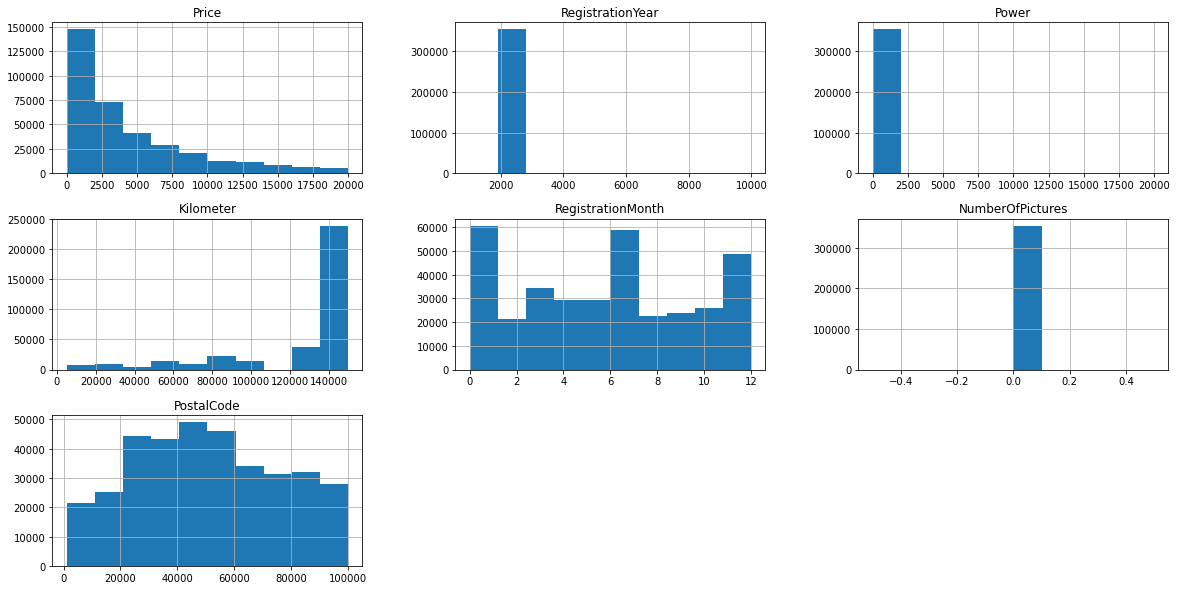

In [19]:
received_data.hist(figsize=(20,10));

In [20]:
sorted(received_data['RegistrationMonth'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

нулевого месяца быть не может. 

In [21]:
list(received_data.FuelType.unique())

['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric']

petrol и gasoline, как lpg и cng по сути одно и тоже. первое это бензин, второе - газ.

In [22]:
list(received_data.VehicleType.unique())

[nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

In [23]:
received_data.Brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

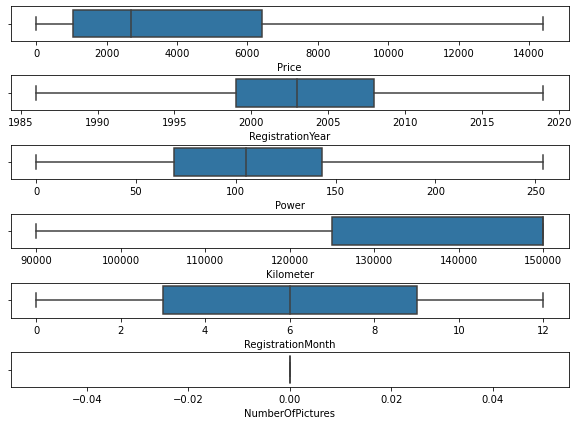

In [24]:
set_box_plot(
    showfliers=False, 
    col=['Price', 'RegistrationYear', 'Power', 'Kilometer',
         'RegistrationMonth', 'NumberOfPictures',
        ])

как примерно должны выглядеть данные

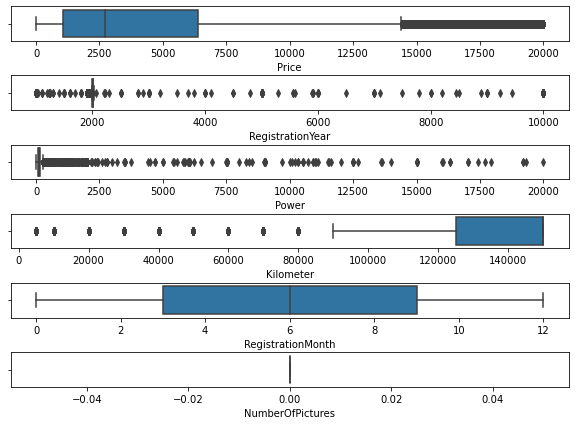

In [25]:
set_box_plot(
    showfliers=True,
    col=[
        'Price', 'RegistrationYear', 'Power', 'Kilometer',
        'RegistrationMonth', 'NumberOfPictures',
    ])

как это выглядит сейчас

In [26]:
old_shape

(354369, 15)

### Краткий вывод

при работе над разделом обнаружено, что  в предоставленных данных присутствуют:
* пропуски;
* дубликаты явные и неявные;
* выбросы;
* пропуски;
* некорректные значения;
* несовпадение типов;
* ненужные столбцы;
* геоданные.

## Подготовка данных

приведем названия столбцов к camel_case

In [27]:
tmp=[]
for i in range(old_shape[1]):
    tmp.append(edit_col(received_data.columns[i]))
received_data.columns = tmp
received_data.index.name = edit_col(received_data.index.name)

заменим тип данных для полей с датой

In [28]:
received_data = edit_datetime(
    received_data,
    columns=['date_created'],
    format='%Y-%m-%d %H:%M:%S',
)
received_data = edit_datetime(
    received_data,
    columns=['last_seen'],
    format='%Y-%m-%d %H:%M:%S',
)
received_data.index = pd.to_datetime(received_data.index, format='%Y-%m-%d %H:%M:%S')
received_data.sort_index(inplace=True)

начнем с простого..
удалим дубликаты и лишний, неинформативный столбец.

In [29]:
received_data.drop_duplicates(inplace=True)
received_data.drop(columns='number_of_pictures', inplace=True)

посмотрим на разброс цен в 90% данных. 

In [30]:
tmp = [received_data.price.quantile(0.04), received_data.price.quantile(0.94)]
tmp

[100.0, 13900.0]

0 это очень низкаяцена для машины, в качестве нижнего порога поставим цену в 100. и обрежем по этим значениям

In [31]:
received_data = received_data.loc[(received_data.price >= tmp[0]) &
                                  (received_data.price <= tmp[1])]

посмотрим, что с мощностью..

массовый сегмент автомобилей в зависимость от мощности двигателя находится примерно в промежутке от 50 до 250 лс

обрежем выбросы по этим значениям

In [32]:
received_data = received_data.loc[(received_data.power >= 50) &
                                  (received_data.power <= 250)]

посмотрим на год регистрации автомобиля

In [33]:
print('от', received_data.registration_year.min(),
      'до', received_data.registration_year.max())

от 1000 до 9999


год регистрациии не может превышать дату последнего просмотра. значит крайний год 2016. удалим все, что больше него 

первый автомобиль появился в 1855 году, но это частный случай. первый массовый автомобиль появился в 1908 году  модель «Т», от компании Форд

обрежем данные по этому нижнему пределу

In [34]:
received_data = received_data.loc[
    (received_data.registration_year >= 1908) &
    (received_data.registration_year <= received_data.index.max().year)]

Если будут несовпадения в месяцах удалим их позже

разберемся с почтовыми кодами..

по почтовым кодам можно установить район, в районе можно выделить популярные модели у пределенных брендов и по этим данным заполнить пропуски в моделях.  

регион был определен в ручную, по данным с сайта https://worldpostalcode.com, путем проверки нескольких индексов.

данные по почтовым кодам и их отношению к федеральной земле получены с сайта <a href='https://www.suche-postleitzahl.org/'>Postleitzahlen Deutschland</a>



In [35]:
received_data = received_data.join(
    pd.read_csv(
        'https://downloads.suche-postleitzahl.org/v2/public/zuordnung_plz_ort.csv',
        #index_col='plz'
    )
    [['bundesland', 'plz']].drop_duplicates().set_index('plz').sort_index(),
    on='postal_code')

In [36]:
received_data.duplicated().sum()

0

востановим данные по моделям..
исходя из бренда и региона отберем самые популярные модели и запишем их в пропуски

In [37]:
tmp = get_group_col(
    data=received_data, cols=[
        'brand',
        'bundesland',
        'model', 
        'date_created'
    ])

In [38]:
for i in range(0, tmp.shape[0]):
    received_data.loc[
        (received_data.brand == tmp.iloc[i].brand) &
        (received_data.bundesland == tmp.iloc[i].bundesland) &
        (received_data.model.isna()),
        ['model',]] = tmp.iloc[i].model

посмотрим на оставшиеся пропуски..

In [39]:
received_data[received_data.model.isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,bundesland
date_crawled,,,,,,,,,,,,,,,
2016-03-05 14:06:24,10900,suv,2003,auto,245,NaN,150000,11,petrol,sonstige_autos,no,2016-03-05,56072,2016-04-06 22:15:33,Rheinland-Pfalz
2016-03-05 14:14:14,4850,suv,2001,auto,238,NaN,150000,5,lpg,sonstige_autos,no,2016-03-03,65232,2016-03-08 16:52:08,Hessen
2016-03-05 14:17:09,11200,convertible,1979,manual,69,NaN,80000,7,petrol,sonstige_autos,no,2016-03-04,35756,2016-04-05 11:50:08,Hessen
2016-03-05 14:18:08,3000,coupe,1994,auto,148,NaN,5000,6,petrol,sonstige_autos,NaN,2016-03-04,65614,2016-03-06 04:16:08,Hessen
2016-03-05 14:18:55,8500,bus,2007,manual,136,NaN,150000,5,gasoline,sonstige_autos,no,2016-03-04,60389,2016-04-07 09:15:59,Hessen


оставшиеся пропуски принадлежат бренду "другие автомобили", что ни как не поможет заказчику. удалим

In [40]:
received_data=received_data[~received_data.model.isna()]

посмотрим на тип транспортного средства.

и как пользователи заполняют это поле, на примере toyota corolla

In [41]:
get_vehicle_type(received_data, test=True)

date_created
brand  model   vehicle_type              
toyota corolla sedan                  347
               wagon                  101
               small                   63
               bus                     32
               coupe                    7
               other                    2

разные пользователи задают значение этого поля по разному, хотя речь идет о одном автомобиле. 
для уменьшения количества пропусков пройдемся по данным и востановим значения из имеющихся в таблице.

есть даже микроавтобус)
но самый популярный - седан. пойдем по этому пути и для пропущенных значений выберем самое популярное значение на основе марки и модели

In [42]:
tmp = get_group_col(
    data=received_data, cols=[
        'brand',
        'model',
        'vehicle_type', 
        'date_created'
    ])

In [43]:
%%time
for i in range(1, tmp.shape[0]):
    received_data.loc[
        (received_data.brand == tmp.iloc[i].brand) &
        (received_data.model == tmp.iloc[i].model) &
        (received_data.vehicle_type.isna()),
        ['vehicle_type']] = tmp.iloc[i].vehicle_type

CPU times: user 9.68 s, sys: 0 ns, total: 9.68 s
Wall time: 9.68 s


посмотрим на данные по типу топлива. 

In [44]:
received_data.groupby([
    'brand',
    'model',
    'vehicle_type',
    'bundesland',
    'fuel_type'
    ])['price'].count()

brand       model     vehicle_type  bundesland              fuel_type
alfa_romeo  145       coupe         Bayern                  petrol        1
                      other         Saarland                petrol        1
                      sedan         Baden-Württemberg       petrol        3
                                    Bayern                  petrol        3
                                    Hamburg                 petrol        1
                                                                         ..
volvo       xc_reihe  wagon         Mecklenburg-Vorpommern  gasoline      2
                                    Nordrhein-Westfalen     gasoline     12
                                    Rheinland-Pfalz         gasoline      1
                                    Sachsen                 gasoline      1
                                    Schleswig-Holstein      gasoline      1
Name: price, Length: 16244, dtype: int64

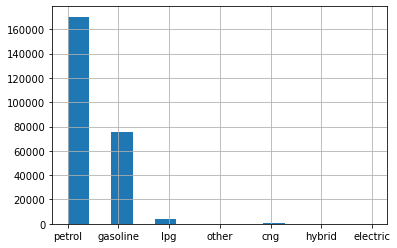

In [45]:
received_data['fuel_type'].hist(bins=14);

в подавляющем большинстве тип топлива petrol и gasoline, что по сути одно и тоже.

заполним пропуски по моде.)

In [46]:
received_data.fuel_type.fillna(value=received_data.fuel_type.mode()[0], inplace=True)

Пришла пора коробки передач

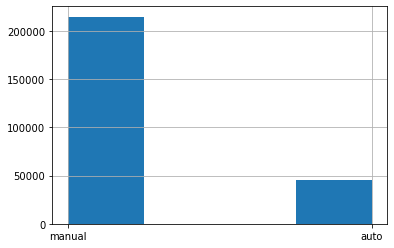

In [47]:
received_data['gearbox'].hist(bins=4);

In [48]:
received_data.gearbox.fillna(
    value=received_data.gearbox.mode()[0],
    inplace=True)

рассмотрим пропуски в repaired 

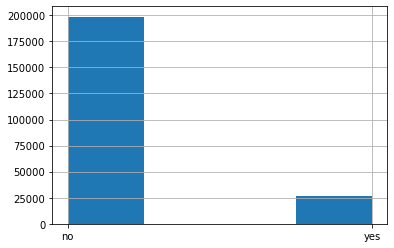

In [49]:
received_data['repaired'].hist(bins=4);

подавляющее большинство указанно как 'не ремонтировалось', но этот параметр может существенно влиять на стоимость. 
во этому заполним пропуски заглушками

In [50]:
received_data.repaired.fillna(value='no_info',  inplace=True)

In [51]:
received_data.isna().sum()

price                   0
vehicle_type            0
registration_year       0
gearbox                 0
power                   0
model                   0
kilometer               0
registration_month      0
fuel_type               0
brand                   0
repaired                0
date_created            0
postal_code             0
last_seen               0
bundesland            257
dtype: int64

остались пропуски в ошибочно указанных почтовых кодах, к которым не нашлось информации о регионе. удалим их

In [52]:
received_data.dropna(inplace=True)

Посмотрим, что осталось в данных

In [53]:
f'осталось {received_data.shape[0]/old_shape[0]:.2%} данных'

'осталось 74.68% данных'

In [54]:
received_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,bundesland
date_crawled,,,,,,,,,,,,,,,
2016-03-05 14:06:22,150,small,1997,manual,75,polo,150000,4,petrol,volkswagen,no,2016-03-05,35789,2016-03-27 17:16:15,Hessen
2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05,57080,2016-03-06 18:29:35,Nordrhein-Westfalen
2016-03-05 14:06:24,6200,convertible,2006,manual,135,megane,90000,9,petrol,renault,no,2016-03-05,35764,2016-03-24 09:16:44,Hessen
2016-03-05 14:06:24,799,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-05,35708,2016-03-09 15:19:01,Hessen
2016-03-05 14:06:25,3700,small,2007,manual,75,twingo,60000,9,petrol,renault,no,2016-03-05,55437,2016-04-06 22:15:40,Rheinland-Pfalz


в даннных остались абсолютные даты, надо их перевести в относительные, а именно из месяца и года реристрации и даты создания обьявления вычислить время владения автомобилем.
это даст данные о сроке владения на дату создания обьявления.
если расчитывать дату относиельно даты последнего просмотра, то ее придется постоянно пересчитывать, от чего рекомендации по стоимости будут меняться.

In [55]:
%%time
received_data['age_year'] = received_data.agg(
    lambda x: (
        x.date_created.year - x.registration_year ), axis=1)

received_data['age_month'] = received_data.agg(
    lambda x: (
        x.date_created.month - x.registration_month), axis=1)


CPU times: user 11 s, sys: 199 ms, total: 11.2 s
Wall time: 11.2 s


избавимся от отрицательных месяцев

In [56]:
received_data.loc[
    received_data.age_month<=0,
    ['age_year',]] = received_data.loc[
    received_data.age_month<=0,
    ['age_year',]
] - 1

received_data.loc[
    received_data.age_month<=0, 
    ['age_month',]
] = received_data.loc[
    received_data.age_month<=0, 
    ['age_month',]] + 12

если получился отрицательный год, значит дата регистрации была моложе, чем дата создания обьявления. если данные былибы из социальной сети, тогда такое было бы возможно, для обьявлений о продаже такого не может быть. удалим обьявления с отрицательным годом

In [57]:
received_data = received_data.loc[received_data['age_year'] > -1]

In [58]:
print(sorted(received_data['age_month'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [59]:
print(sorted(received_data['age_year'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 74, 78, 105, 106]


в нашем случае можно будет обновлять возраст раз в месяц, для всех автомобилей и в связи с этим корректироват рекомендации по ценам.

In [60]:
f'по итогу осталось {received_data.shape[0]/old_shape[0]:.2%} данных'

'по итогу осталось 73.56% данных'

удалили 26,44%.. это много, но зато очистили данные от выбросов, откровенных манипуляций с датами и оставили данные с ценами, востановили марки и модели в некоторых обьявлениях 

удалим абсолютные даты и почтовый код 

In [61]:
data_to_model = received_data.drop(
    columns=[
        'registration_month', 'registration_year',
        'date_created', 'last_seen', 'postal_code'
    ]
)

In [62]:
data_to_model.head(5)

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,bundesland,age_year,age_month
date_crawled,,,,,,,,,,,,
2016-03-05 14:06:22,150,small,manual,75,polo,150000,petrol,volkswagen,no,Hessen,18,11
2016-03-05 14:06:23,3999,wagon,manual,220,a6,150000,petrol,audi,no,Nordrhein-Westfalen,12,8
2016-03-05 14:06:24,6200,convertible,manual,135,megane,90000,petrol,renault,no,Hessen,9,6
2016-03-05 14:06:24,799,small,manual,60,polo,150000,petrol,volkswagen,no,Hessen,18,4
2016-03-05 14:06:25,3700,small,manual,75,twingo,60000,petrol,renault,no,Rheinland-Pfalz,8,6


### Краткий вывод:

при работе над разделом произведено:
* удалены пропуски во всех столбцах, ноекторорые востановлены из аналогичных;
* обогащены геоданные данные, установлен регион происходления данных;
* удалены выбросы, где это было возможно;
* удалены и востановлены некорректны значения в данных;
* созданы новые столбцы с данными подходящими для обучения;
* удалены все ненужные столбцы;
* по геоданным востановлены некоторые значения;
* неявные дубликаты было решено оставить, для сохранения совместимомти с новыми данными.

## Обучение моделей

разделим данные на выборки

In [63]:
train_data, test_data = train_test_split(
    data_to_model,
    shuffle=False,
    test_size=.25
)

тк данные были отсортированы по индексу (дате) перемешаем их

In [64]:
train_data = train_data.sample(frac=1, random_state=RANDOM_STATE)
test_data = test_data.sample(frac=1, random_state=RANDOM_STATE)

In [65]:
print(f'доля train_data = {train_data.shape[0]/received_data.shape[0]:.1%}')
print(f'доля test_data = {test_data.shape[0]/received_data.shape[0]:.1%}')

доля train_data = 75.0%
доля test_data = 25.0%


отделим таргет от выборок

In [66]:
tmp = []
for sample in [test_data, train_data]:
    tmp.append(sample.price.reset_index(drop=True))
    sample.drop(columns='price', inplace=True)
    sample.reset_index(drop=True, inplace=True)
test_target, train_target = tmp

In [67]:
if (test_data.shape[0] == test_data.shape[0] and 
    train_data.shape[0] == train_target.shape[0]):
    print('выборки равны с целевым полем')
else: print('не равны')

выборки равны с целевым полем


In [68]:
train_data.isna().sum()

vehicle_type    0
gearbox         0
power           0
model           0
kilometer       0
fuel_type       0
brand           0
repaired        0
bundesland      0
age_year        0
age_month       0
dtype: int64

In [69]:
data_to_model[data_to_model.model=='rangerover']

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,bundesland,age_year,age_month
date_crawled,,,,,,,,,,,,
2016-03-18 01:57:30,1050,small,manual,103,rangerover,150000,petrol,rover,no_info,Niedersachsen,17,5


применим к текстовым полям порядковое кодирование, но тк у нас есть некоторые поля в единственном экземпляре OrdinalEncoder использовать не получится или придется еще уменьшать набор. 

In [70]:
test_data.head(2)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,bundesland,age_year,age_month
0,wagon,manual,75,astra,150000,petrol,opel,no_info,Bayern,18,12
1,convertible,manual,116,z_reihe,150000,petrol,bmw,no,Nordrhein-Westfalen,17,10


In [71]:
train_data, _ = encode_cat_par(
    data=[train_data, test_data],
    futures=train_target,
    columns=[
        'repaired','brand',
        'fuel_type', 'vehicle_type',
        'gearbox', 'model', 'bundesland',
        ], encoder=MEstimateEncoder())

и стандартизируем

In [72]:
train_data, _ = encode_cat_par(data=[train_data, test_data],
               encoder=RobustScaler())

In [73]:
train_data.head(2)

,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,bundesland,age_year,age_month
0,0.200163,1716.912099,1.848485,0.810269,0.0,0.0,0.619050,0.0,0.295149,0.142857,0.142857
1,0.200163,1716.912099,1.227273,0.629816,0.0,1.0,0.582027,0.0,1.084040,-0.857143,-0.857143


создадим таблицы для сохранения результата

In [74]:
data_rouger = pd.DataFrame()

обучим модели

In [75]:
model, tmp = model_func(
    model=Ridge,
    random_state={'random_state':RANDOM_STATE,},      
    param_grid={
        'alpha': np.arange(0.0, 1, 0.01),
        'solver':['auto', 'lsqr']
    },
    train=train_data,
    train_valid=train_target, 
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

In [76]:
model, tmp = model_func(
    model=LinearRegression,
    train=train_data,
    train_valid=train_target,
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

In [77]:
model, tmp = model_func(
    model=CatBoostRegressor,
    random_state={'verbose':False},
    train=train_data,
    train_valid=train_target,
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

In [78]:
model, tmp = model_func(
    model=DummyRegressor,
    param_grid={'strategy': ['mean']},
    train=train_data,
    train_valid=train_target,
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

In [79]:
model, tmp = model_func(
    model=LGBMRegressor,
    param_grid={
        'n_estimators' : np.array([50, 100, 500]),
        'max_depth': np.arange(1, 20),
        'device_type':['cpu'], 
    },
    train=train_data,
    train_valid=train_target,
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

In [80]:
model, tmp = model_func(
    model=LGBMRegressor,
    train=train_data,
    train_valid=train_target,
)
data_rouger = pd.concat([data_rouger, tmp], axis=0, ignore_index=False)

поменяем расположение колонок

In [81]:
data_rouger=data_rouger[['name', 'rsme_train', 'all_time_sec',
                     'model', 'best_model', 'best_param',]]

In [82]:
data_rouger.sort_values(by='rsme_train')[0:3].drop(
    columns=['model', 'best_model', 'best_param'])

,name,rsme_train,all_time_sec
0,CatBoostRegressor,1237.151223,60.907889
0,LGBMRegressor,1295.189907,3.49491
0,LGBMRegressor,1971.549893,254.342731


In [83]:
data_rouger.sort_values(by='all_time_sec')[0:3].drop(
    columns=['model', 'best_model', 'best_param'])

,name,rsme_train,all_time_sec
0,DummyRegressor,3395.061552,0.06593
0,LinearRegression,2074.854281,0.563539
0,LGBMRegressor,1971.549893,254.342731


### Краткий вывод

в ходе работы над разделом:
* разделили набор данных на учебный и проверочный
* обучили две линейтые модели (Ridge и LinearRegression), две модели с бустингом (CatBoostRegressor и LGBMRegressor) и DummyRegressor для стравнения
* посчитали метрику RSME для каждой модели (для тренировочных и проверочных данных)
* посчитали время работы кадой модели (для тренировочных и проверочных данных)
* записали все данные в сводную таблицу



## Анализ моделей

в ходе работы над предидущим разделом были обучены 5 моделей, две из которых линейные, две с бустингом и одна Dummy

модели показали следующие результаты

In [84]:
data_rouger.sort_values(by='all_time_sec').drop(
    columns=['model', 'best_model',])

,name,rsme_train,all_time_sec,best_param
0,DummyRegressor,3395.061552,0.06593,best_param={'strategy': 'mean'}
0,LinearRegression,2074.854281,0.563539,best_param={}
0,LGBMRegressor,1971.549893,254.342731,"best_param={'device_type': 'cpu', 'max_depth': 1, 'n_estimators': 50}"
0,LGBMRegressor,1295.189907,3.49491,best_param={}
0,Ridge,2092.621226,48.495947,"best_param={'alpha': 0.99, 'solver': 'lsqr'}"
0,CatBoostRegressor,1237.151223,60.907889,best_param={}



    исходя из полученных результатов и потребностей заказчика (высыокая скорость обучения, качество предсказания и скорость предсказания)можно сказать следующее:
* показателям высокой скорости отвечает модель DummyRegressor, но качество предсказания у этой модели никакое, тк она делает "предсказание" исхдя из часто встречающегося значения, от чего иногда попадает в цель.
* следующими, по скорости идут модели LinearRegression и Ridge, качество этих модели вполне вписывается в потребности заказчика, как по скорости, так и по метрике
* обучение модели LGBMRegressor, без подбора параметров, занимает около 2 секунд (почти в 10 раз больше времени, чем у LinearRegression), при этом качество предсказания возрастает пости в 2 раза. 
* самое продолжительное время обучения занимает у CatBoostRegressor и  LGBMRegressor (с подбором параметров) занимает много времени около 22 и 103 секунд соответсятвенно, при качество предсказания LGBMRegressor(с подбором параметров) падает почти в 2 раза, а у CatBoostRegressor, качество понижается незначительно, а скорость работы возрастает почти в 100 раз.

исходя из описанного выше и учитывая, что заказчик на первое место поставил - качество предсказания, потом - скорость предсказания и последним параметром идет - время обучения, можно рекомендовать использовать CatBoostRegressor или LGBMRegressor, с значениями по умолчанию, ТК эти модели имеют лучшее качество предсказания за приемлемое время, при этом CatBoostRegressor имеет низкую скорость обучения (этот параметр не сильно важен заказчику), а LGBMRegressor немного худшее предсказание(критичный параметр). 

предпочтительным выглядит вариант использования CatBoostRegressor, без параметров.


## Тестирование лучшей модели

In [85]:
train_data, valid_data = train_test_split(
    data_to_model, shuffle=False, test_size=.4
)
    
valid_data, test_data = train_test_split(
    valid_data, shuffle=False, test_size=.5
)

tmp = []
for sample in [test_data, train_data, valid_data]:
    tmp.append(sample.price.reset_index(drop=True))
    sample.drop(columns='price', inplace=True)
    sample.reset_index(drop=True, inplace=True)
test_target, train_target, valid_target = tmp

train_data, valid_data, test_data = encode_cat_par(
    data=[train_data, valid_data, test_data],
    futures=train_target,
    columns=[
        'repaired','brand',
        'fuel_type', 'vehicle_type',
        'gearbox', 'model', 'bundesland',
        ], encoder=MEstimateEncoder())

train_data, valid_data, test_data= encode_cat_par(data=[train_data, valid_data, test_data],
               encoder=RobustScaler())



model = CatBoostRegressor(verbose=False)
times = datetime.now()
model.fit(train_data, train_target)
print('время на fit', (datetime.now() - times).total_seconds())

times=datetime.now()
predict = model.predict(valid_data)
print('время на predict', (datetime.now() - times).total_seconds())
print('RMSE', mean_squared_error(predict, valid_target, squared=False))

times=datetime.now()
predict = model.predict(test_data)
print('время на test', (datetime.now() - times).total_seconds())
print('RMSE', mean_squared_error(predict, test_target, squared=False))

время на fit 9.60805
время на predict 0.020582
RMSE 1282.8224210372177
время на test 0.021254
RMSE 1261.7462452742004


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
    рассмотрим, что происходит в разделе <b>"обучение модели"</b>, на примере модели <b>Ridge</b>...
    
в поле <b>"Ввод [74]" ноутбука </b> есть код:
     model, tmp = model_func(
        model=Ridge,
        random_state={'random_state':RANDOM_STATE,},      
        param_grid={
            'alpha': np.arange(0.0, 1, 0.01),
            'solver':['auto', 'lsqr']
        },
        train=train_data,
        train_valid=train_target, 
    )

что тут происходит..
    вызывается функция model_func, на вход которой передаются параметры:
    
    model - класс модели,
    random_state = параметры для вызова класса модели,
    param_grid - параметры для кроссвалидации,
    train - данные для обучения,
    train_valid - целевой параметр для обучающей выборки
    
функция (model_func) возвращает 2 параметра:
    
    gs_ridge - лучшие параметры модели, после кросс-валидации
    tmp - словарь с значениями
    
    ссылка на возвраты от функции помещается в переменные model, tmp.
    из tmp создается сводная таблица, с данными получеными на кросс-валидации.
    
следующим этапом вызываются строки:
    
    start = datetime.now()
    dick['rsme_test'].append(ret_rsme(model))
    dick['valid_sec'].append((datetime.now() - start).total_seconds())
    
первую и последнюю опустим..
    
    в строке dick['rsme_test'].append(ret_rsme(model)) происходит следующее:
    
    вызывается функция ret_rsme, которой на вход подаются данные лучшей модели, где считается новый RSME уже на тестовых данных и возвращается в словарь.
    
согласен, неявный вызов это не удобно. переделал на явный, изменил имена преременных, поменял слова валидационную выборку на тестовая. в тексте.
    
    те на этапе "обучение модели" проходит кросс-валидация по обучающей выборке и получение предсказания по тестовой выборке. в тексте она у меня переодически называется валидационной
    
    в связи с издложенным выше - считаю, что дополнительное проведение тестирования будет избыточным!
</div>

## Вывод

в ходе работы над проектом были выполены следующие этапы: 
* Изучение данных, в ходе которого были обнаружены погрешности в данных, а именно:

        дубликаты явные и неявные;
        выбросы;
        пропуски;
        некорректные значения;
        несовпадение типов;
        ненужные столбцы.
* Подготовка данных. На этом этапе: 

        удалены пропуски во всех столбцах, востановлены значения столбцов с параметрами модели, марки, типа кузова тс из аналогичных данных по набору;
        обогащены геоданные. по почтовому коду востановлен регион нахождения тс;
        удалены выбросы, где это было возможно;
        удалены и востановлены некорректны значения в данных (данные из будущего, 0 месяц);
        созданы новые столбцы, на остнове данных о регистрации абсолютные даты заменены на относительные (возраст автомобиля);
        удалены все ненужные столбцы, которые могли помешать обучению;
        неявные дубликаты было решено оставить, для сохранения совместимомти с новыми данными.
* Обучение моделей

        набор данных был разделен на учебный и проверочный к учебному набору применены методы порядкового кодирования, для избавления от текстовых полей и стандартизации, для уменьшения масштаба
        обучено две линейтые модели (Ridge и LinearRegression), две модели с бустингом (CatBoostRegressor и LGBMRegressor) и DummyRegressor для стравнения
        посчтана метрика RSME для каждой модели (для тренировочных и проверочных данных)
        посчитали время работы кадой модели (для тренировочных и проверочных данных)
        записали все данные в сводную таблицу

* Анализ моделей

        показателям высокой скорости отвечает модель DummyRegressor, но качество предсказания у этой модели никакое, тк она делает "предсказание" исхдя из часто встречающегося значения, от чего иногда попадает в цель.
        следующими, по скорости идут модели LinearRegression и Ridge, качество этих модели вполне вписывается в потребности заказчика, как по скорости, так и по метрике
        обучение модели LGBMRegressor, без подбора параметров, занимает около 2 секунд (почти в 10 раз больше времени, чем у LinearRegression), при этом качество предсказания возрастает пости в 2 раза.
        самое продолжительное время обучения занимает у CatBoostRegressor и LGBMRegressor (с подбором параметров) занимает много времени около 22 и 103 секунд соответсятвенно, при качество предсказания LGBMRegressor(с подбором параметров) падает почти в 2 раза, а у CatBoostRegressor, качество понижается незначительно, а скорость работы возрастает почти в 100 раз.
    
       исходя из описанного выше и учитывая, что заказчик на первое место поставил - качество предсказания, потом - скорость предсказания и последним параметром идет - время обучения, можно рекомендовать использовать CatBoostRegressor или LGBMRegressor, с значениями по умолчанию, ТК эти модели имеют лучшее качество предсказания за приемлемое время, при этом CatBoostRegressor имеет низкую скорость обучения (этот параметр не сильно важен заказчику), а LGBMRegressor немного худшее предсказание(критичный параметр). их можно использовать в зависимости от ситуации. 
       предпочтительным выглядит вариант использования CatBoostRegressor, без параметров. 